In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight #样本不平衡 加权
from scipy.stats import randint, uniform

data = pd.read_csv(r'E:\Study\统计建模\python\data\data with AE(latent dim=6).csv')
X = data.drop(columns=['Diagnosis']).values
y = data['Diagnosis'].values
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#样本不平衡 加权
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))  # 转换为字典格式[5](@ref)
class_weights_dict
#sum/2/sum_0   sum/2/sum_1

{0: 0.6515189805561299, 1: 2.1499583027975033}

In [3]:
param_grid = {
    'n_estimators': randint(50,200),
    'learning_rate':uniform(0.1, 1)
}

# 初始化带类别权重的基准模型
base_model = AdaBoostClassifier(
    random_state=42
)

random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=50,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        random_state=42
)

# 执行搜索
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E7ED44B5E0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E7EAA7FB50>},
                   random_state=42, scoring='accuracy')

In [4]:
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'learning_rate': 0.49986097171525545, 'n_estimators': 64}


In [2]:
model = AdaBoostClassifier(
    learning_rate= 0.4998,
    n_estimators=64,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred,digits=4))

Confusion Matrix:
[[30659  1956]
 [ 5493  4431]]
Accuracy: 0.8249
              precision    recall  f1-score   support

           0     0.8481    0.9400    0.8917     32615
           1     0.6938    0.4465    0.5433      9924

    accuracy                         0.8249     42539
   macro avg     0.7709    0.6933    0.7175     42539
weighted avg     0.8121    0.8249    0.8104     42539



In [3]:
#训练集精度
accuracy_score( y_train, model.predict(X_train) )

0.8279773379096338

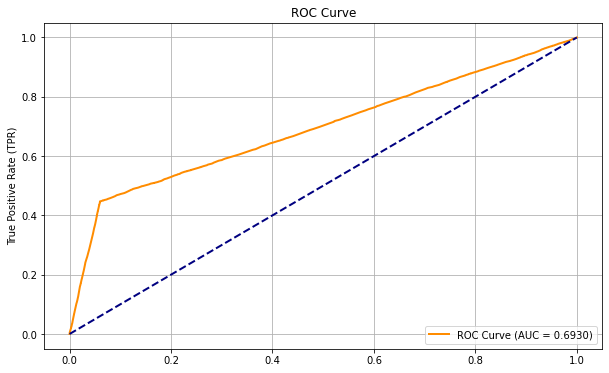

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score=model.predict_proba(X_test)[:,1]
# 计算ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score,pos_label=1)
roc_auc = roc_auc_score(y_test, y_score)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
#保存预测值，为后续画图
# 将y_score转为DataFrame并自定义列名
combined_df = pd.DataFrame({
    'AdaBoost': y_score
})
combined_df.to_csv('AdaBoost.csv', index=False)